# Mock mass-calibration comparing Ragagnin2020 and Diemer2019 Mcs

## 1) imports and constants

In [1]:
import hydro_mc, matplotlib.pyplot as plt, numpy as np, pint
from colossus.cosmology import cosmology
from colossus.halo import concentration
from scipy import optimize
from scipy.stats import norm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import scipy.stats as stats

A_NFW = lambda c: (np.log(1.+c)-c/(1.+c))

ureg = pint.UnitRegistry()
ureg.define('Msun = 1.989e+30*kg')
ureg.define('kpc = 1e3*pc')
h0_units =  ureg.km/ureg.s/ureg.Mpc
G = 6.67408e-11*ureg.m**3/ureg.kg/ureg.s**2

## 2) Routines to get 2D NFW profiles given (rs, rho0) or (M,c, cosmology) 

In [10]:

def get_rho_crit_in_Msun_kpc3(h0):
    return (3*(100.*h0*h0_units)**2/(8*np.pi*G)).to('Msun/kpc^3').magnitude

def get_R_kpc(delta, a, omega_m, h0, M):
    critical_overdensity = hydro_mc.critical_overdensity(delta, a=a, omega_m = omega_m)
    rho_crit_Msun_kpc3 = get_rho_crit_in_Msun_kpc3(h0)
    r_3 = M/(critical_overdensity*4./3.*np.pi*rho_crit_Msun_kpc3)
    r = r_3**(1/3)
    #print('r',r)
    return r 

A_NFW = hydro_mc.f_NFW
sqrt = np.sqrt
log = np.log

def nfw2_return_from_rho0_rs(rho0, rs, radii):
    # si veda Lokas & Mamon 2001 ( https://ui.adsabs.harvard.edu/abs/2001MNRAS.321..155L/abstract )
    a=rs
    b=radii
    v1= -2*rho0*rs*((a**2 *  (a**2-b**2+a * sqrt(-a**2 + b**2)* np.arccos(a/b))/(a**2-b**2)**2))
    v2 = 2*rho0*a**3 * (1./(-a**2+b**2)+(a * np.arccosh(a/b))/(a**2-b**2)**(1.5))
    # we check if radii is scalar or array
    if hasattr(radii, "__getitem__") and not np.array(radii).shape==(): 
        mask = np.isnan(v1)
        v1[mask] = v2[mask]
        return v1
    else:
        return v1 if np.isnan(v2) else v2

def nfw2_profile_from_M_c(M,c, delta, a, omega_m, h0,radii):
    #print('M',M_1e10Msun, M)
    Rhalo = get_R_kpc(delta, a, omega_m, h0, M)
    rs = Rhalo/c
    rho0 = M/(4./3.*np.pi*rs**3)*1/(3*A_NFW(c))
    a=rs
    #print('rho0', rho0, 'rs', rs, 'r',r)
    return nfw2_return_from_rho0_rs(rho0, rs, radii)

## 3) Routine to generate noisy NFW profile with a given S/N


/home/moon/ragagnin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in sqrt
/home/moon/ragagnin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in arccos
/home/moon/ragagnin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in arccosh
/home/moon/ragagnin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in power


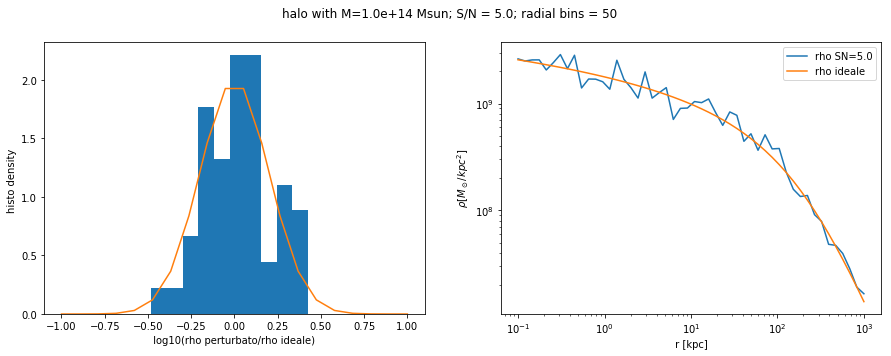

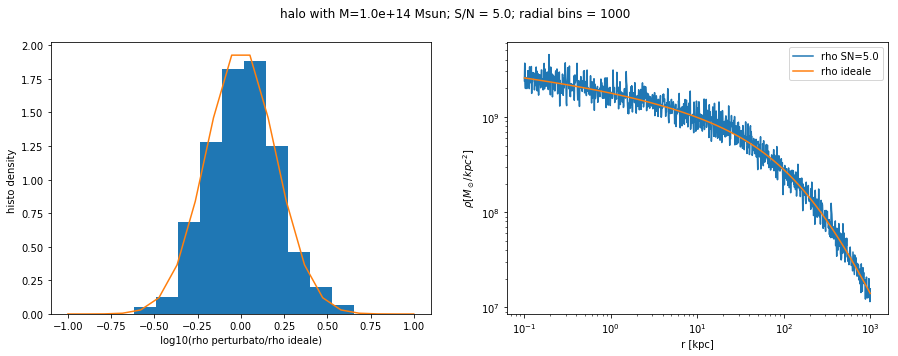

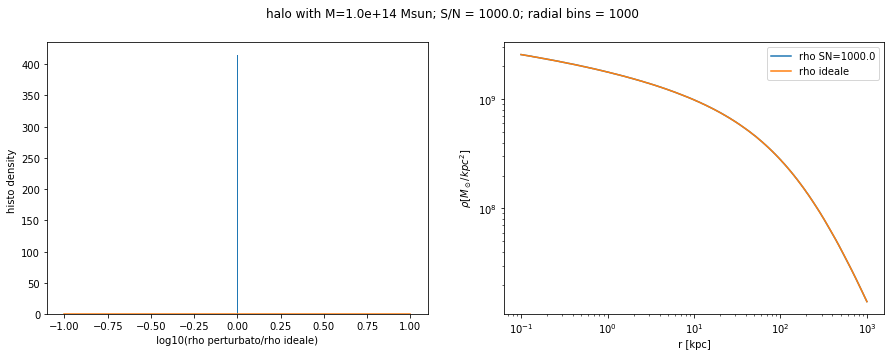

In [12]:

def genera_profilo_con_SN(M, c,  a, delta, omega_m, omega_b, sigma8, h0, sn, radii_n=50, plotta=False):

    radii = np.logspace(-1, 3, radii_n)
    rho_ideale = nfw2_profile_from_M_c(M, c, delta, a, omega_m,   h0, radii)
    rho_perturbato = rho_ideale * np.exp(np.random.normal(loc=0, scale=1./sn, size =  radii_n))
    rho_perturato_errore = rho_perturbato*1./sn
    if plotta:
        f, axes = plt.subplots(1,2, figsize=(15,5))
        ax = axes[0]
        ax.hist(np.log(rho_perturbato/rho_ideale), density=True)
        xs = np.linspace(-1,1,20)
        ax.plot(xs, stats.norm.pdf(xs, 0., 1./sn))
        ax.set_xlabel(' log10(rho perturbato/rho ideale) ')
        ax.set_ylabel('histo density ')
        
        ax = axes[1]        
        ax.plot(radii,rho_perturbato, label = 'rho SN=%.1f'%sn )
        ax.plot(radii,rho_ideale, label = 'rho ideale' )
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_xlabel(' r [kpc] ')
        ax.set_ylabel(r' $\rho [M_\odot/kpc^2]$ ')
        ax.legend()
        f.suptitle('halo with M=%.1e Msun; S/N = %.1f; radial bins = %d'%(M, sn, radii_n))
    return radii, rho_ideale, rho_perturbato, rho_perturato_errore


# testo che il profilo abbia veramente SN=5 (cioe coincida con gaussiana con sigma = .25)
genera_profilo_con_SN(M=1.e14, c=4., a=0.4, delta='200c', omega_m=0.3, omega_b=0.04, sigma8=0.8, h0=0.7, sn = 5., radii_n=50, plotta=True);

# testo che il profilo abbia veramente SN=5 (cioe coincida con gaussiana con sigma = .25)
genera_profilo_con_SN(1.e14, c=4.,  a=0.4, delta='200c', omega_m=0.3, omega_b=0.04, sigma8=0.8, h0=0.7, sn = 5., radii_n=1000, plotta=True);

# testo che il profilo abbia veramente SN=5 (cioe coincida con gaussiana con sigma = .25)
genera_profilo_con_SN(1.e14, c=4.,  a=0.4, delta='200c', omega_m=0.3, omega_b=0.04, sigma8=0.8, h0=0.7, sn = 1000., radii_n=1000, plotta=True);


## 4) Mass calibration routines with Ragagnin2020 and Diemer2019 Mcs rels

In [4]:
def nfw2_profile_from_M200c_Ragagnin2020(M, a, delta, omega_m, omega_b, sigma8, h0,radii):
    Rhalo = get_R_kpc(delta, a, omega_m, h0, M)
    c = hydro_mc.concentration_from_mc_relation(delta, M=M, a=a, omega_m = omega_m, omega_b = omega_b, sigma8=sigma8, h0=h0)
    rs = Rhalo/c
    rho0 = M/(4./3.*np.pi*rs**3)*1/(3*A_NFW(c))
    return nfw2_return_from_rho0_rs(rho0, rs, radii)

def nfw2_profile_from_M200c_Diemer2019(M, a, delta, omega_m, omega_b, sigma8, h0,radii):

    _params = {'flat': True, 
               'H0': h0*100., 
               'Om0': omega_m, 
               'Ob0': omega_b,
               'sigma8': sigma8,
              'ns':.963}
    Rhalo = get_R_kpc(delta, a, omega_m, h0, M)
    _cosmo = cosmology.setCosmology('myCosmo', _params)
    cosmology.setCurrent( _cosmo)
    if M>1e16:
        return np.nan
    #diemer vuole masse/h
    #c = concentration.modelDiemer19(M*h0, 1./a-1.)[0]
    c = concentration.concentration(M*h0, delta, 1./a-1., model='diemer19')[0]
    rs = Rhalo/c
    rho0 = M/(4./3.*np.pi*rs**3)*1/(3*A_NFW(c))
    return nfw2_return_from_rho0_rs(rho0, rs, radii)
def nfw2_profile_from_M200c_Diemer2015(M, a, delta, omega_m, omega_b, sigma8, h0,radii):

    _params = {'flat': True, 
               'H0': h0*100., 
               'Om0': omega_m, 
               'Ob0': omega_b,
               'sigma8': sigma8,
              'ns':.963}
    Rhalo = get_R_kpc(delta, a, omega_m, h0, M)
    _cosmo = cosmology.setCosmology('myCosmo', _params)
    cosmology.setCurrent( _cosmo)
    if M>1e16:
        return np.nan
    #diemer vuole masse/h
    #c = concentration.modelDiemer19(M*h0, 1./a-1.)[0]
    c = concentration.concentration(M*h0, delta, 1./a-1., model='diemer15')[0]
    rs = Rhalo/c
    rho0 = M/(4./3.*np.pi*rs**3)*1/(3*A_NFW(c))
    return nfw2_return_from_rho0_rs(rho0, rs, radii)
def nfw2_profile_from_M200c_Ludlow2016(M, a, delta, omega_m, omega_b, sigma8, h0,radii):

    _params = {'flat': True, 
               'H0': h0*100., 
               'Om0': omega_m, 
               'Ob0': omega_b,
               'sigma8': sigma8,
              'ns':.963}
    Rhalo = get_R_kpc(delta, a, omega_m, h0, M)
    _cosmo = cosmology.setCosmology('myCosmo', _params)
    cosmology.setCurrent( _cosmo)
    if M>1e16:
        return np.nan
    #diemer vuole masse/h
    #c = concentration.modelDiemer19(M*h0, 1./a-1.)[0]
    c = concentration.concentration(M*h0, delta, 1./a-1., model='ludlow16')[0]
    rs = Rhalo/c
    rho0 = M/(4./3.*np.pi*rs**3)*1/(3*A_NFW(c))
    return nfw2_return_from_rho0_rs(rho0, rs, radii)


def calibra_massa_su_profilo(rho, log_rho_err, funzione_profilo_M_radii):
       
    errorfunc = lambda logM: (np.log(funzione_profilo_M_radii(np.exp(logM))) - np.log(rho))/log_rho_err  
    
    p1, success = optimize.leastsq( errorfunc, x0 = 14.)
    if not success:
        print(p1, success)
        raise Exception('ahi ahi toppai!')
    return np.exp(p1)

def calibra_massa_Ragagnin2020(radii, rho, log_rho_err, a, delta, omega_m, omega_b, sigma8, h0):
    M = calibra_massa_su_profilo(
       rho, log_rho_err,
        lambda M: nfw2_profile_from_M200c_Ragagnin2020(M, a, delta, omega_m, omega_b, sigma8, h0,radii)
    )
    c = hydro_mc.concentration_from_mc_relation(delta, M=M, a=a, omega_m = omega_m, omega_b = omega_b, sigma8=sigma8, h0=h0)
    return M,c

def calibra_massa_Diemer2019(radii, rho, log_rho_err, a, delta, omega_m, omega_b, sigma8, h0):
    M = calibra_massa_su_profilo(
      rho, log_rho_err,
        lambda M: nfw2_profile_from_M200c_Diemer2019(M, a,  delta, omega_m, omega_b, sigma8, h0,radii)
    )
    c = concentration.concentration(M*h0, delta, 1./a-1., model='diemer19')[0]
    return M,c
def calibra_massa_Diemer2015(radii, rho, log_rho_err, a, delta, omega_m, omega_b, sigma8, h0):
    M = calibra_massa_su_profilo(
      rho, log_rho_err,
        lambda M: nfw2_profile_from_M200c_Diemer2015(M, a,  delta, omega_m, omega_b, sigma8, h0,radii)
    )
    c = concentration.concentration(M*h0, delta, 1./a-1., model='diemer15')[0]
    return M,c

def calibra_massa_Ludlow2016(radii, rho, log_rho_err, a, delta, omega_m, omega_b, sigma8, h0):
    M = calibra_massa_su_profilo(
      rho, log_rho_err,
        lambda M: nfw2_profile_from_M200c_Ludlow2016(M, a,  delta, omega_m, omega_b, sigma8, h0,radii)
    )
    c = concentration.concentration(M*h0, delta, 1./a-1., model='ludlow16')[0]
    return M,c

## 5) Routine to generate a mock (M,c) given a model (e.g.  Okabe2011)

In [99]:
def random_with_asymmetric_errors(a, eplus, eminus):
    #given $a ^{+eplus} _{-eminus}$ gives a random number in this interval
    x = np.arandom.rand()
    amin = a-eminus
    amax = a+eplus
    adelta = amax-amin
    return x*(adelta)+amin

def get_M_c_from_model(model='Okabe2011', M=None, delta='200c', omega_m = None, omega_b = None, sigma8 = None, h0 = None, a=None):
        
    if model=='Ragagnin2020':
        omega_m = 0.3
        sigma8 = 0.7
        h0=0.65
        omega_b = 0.05
        a=0.9
        c = hydro_mc.concentration_from_mc_relation(delta, M=    M, a=a, omega_m = omega_m,  omega_b =omega_b,  sigma8=sigma8,  h0=h0)
        c = c * np.exp(np.random.normal(loc=0, scale=.3 ))
        return M,c, omega_m, omega_b, sigma8, h0,a
    elif model=='Okabe2011':
        omega_m = 0.3
        sigma8 = 0.8
        h0=0.7
        omega_b = 0.04
        z = 0.3
        a=1./(1.+z)

        A = -0.37 #np.random.normal(loc=-0.37, scale=0.2)
        C = 5.76 #5.75 #np.random.normal(loc=5.75, scale=2.)
        c = C * (M/(1e14/h0))**(A)
        #c = c*np.random.normal(np.log10(c), scale=0.18)
        c = c  * 10.**(np.random.normal(loc=0, scale=.18  ))

        return M,c, omega_m, omega_b, sigma8, h0,a
    elif model=='Diemer2019':
        omega_m = 0.3
        sigma8 = 0.8
        h0=0.7
        omega_b = 0.04
        z = 0.3
        a=1./(1.+z)        # scommentare se si vuole provare lo stesso esperimento calibrando un profilo generato con Mc di Diemer
        c = concentration.concentration(M*h0, delta, 1./a-1., model='diemer19')
        return M,c, omega_m, omega_b, sigma8, h0,a
    elif model=='Capasso2019 0.39<z<0.44':
        if M is not None:
            raise Exception('if model==Capasso2020, you need to pass a=None and M=None,'+
                            ' to ensure that I will set it from'+
                            ' https://ui.adsabs.harvard.edu/abs/2019MNRAS.482.1043C/abstract ')
        omega_m = 0.3
        sigma8 = 0.8
        h0=0.7
        omega_b = 0.04 #0.045696
        
        # scommentare se si vuole provare lo stesso esperimento calibrando un profilo generato con Mc di Diemer
        #z= .4 #np.random.normal(loc=(0.2+.4)/2., scale=(.4-.2)/2.)
        M = np.random.normal(10.57, scale=1.6)*1e14
        c = np.random.normal(4.1, scale=1.5) 
        z= .4 #np.random.normal(loc=(0.2+.4)/2., scale=(.4-.2)/2.)

        a=1./(1.+z)
        return M,c, omega_m, omega_b, sigma8, h0,a
    elif model=='Capasso2019 z<0.38':
        if M is not None:
            raise Exception('if model==Capasso2020, you need to pass a=None and M=None,'+
                            ' to ensure that I will set it from'+
                            ' https://ui.adsabs.harvard.edu/abs/2019MNRAS.482.1043C/abstract ')
        omega_m = 0.3
        sigma8 = 0.8
        h0=0.7
        omega_b = 0.04 #0.045696

        M = np.random.normal(9.44, scale=1.7)*1e14
        c = np.random.normal(5.4, scale=2.1) 
        z=   .3#np.random.rand()*(.38-.26)+.26
        a=1./(1.+z)
        return M,c, omega_m, omega_b, sigma8, h0,a
    elif model=='Capasso2019':
        if M is not None:
            raise Exception('if model==Capasso2020, you need to pass a=None and M=None,'+
                            ' to ensure that I will set it from'+
                            ' https://ui.adsabs.harvard.edu/abs/2019MNRAS.482.1043C/abstract ')
        omega_m = 0.3
        sigma8 = 0.8
        h0=0.7
        omega_b = 0.04 #0.045696

        M = np.random.normal(8.7, scale=1.7)*1e14
        c = np.random.normal(5.1, scale=2.1) 
        z=   .3#np.random.rand()*(.38-.26)+.26
        a=1./(1.+z)
        return M,c, omega_m, omega_b, sigma8, h0,a
    else:
        raise Exception('model must be Ragagnin2020 o Okabe2011 o Diemer2019')

print('Model = Ragagnin2020  M=%.2eMsun, c=%.1f, omega_m=%.3f, omega_b=%.3f, sigma8=%.3f, h0=%.3f, a=%.3f'%(get_M_c_from_model(model='Ragagnin2020', M=1e14 )))
print('Model = Okabe2011,   M=%.2eMsun, c=%.1f, omega_m=%.3f, omega_b=%.3f, sigma8=%.3f, h0=%.3f, a=%.3f'%(get_M_c_from_model(model='Okabe2011', M=1e14 )))
print('Model = Capasso2019,  M=%.2eMsun, c=%.1f, omega_m=%.3f, omega_b=%.3f, sigma8=%.3f, h0=%.3f, a=%.3f'%(get_M_c_from_model(model='Capasso2019 z<0.38', M=None )))
print('Model = Capasso2019,  M=%.2eMsun, c=%.1f, omega_m=%.3f, omega_b=%.3f, sigma8=%.3f, h0=%.3f, a=%.3f'%(get_M_c_from_model(model='Capasso2019 0.39<z<0.44', M=None )))


Model = Ragagnin2020  M=1.00e+14Msun, c=3.8, omega_m=0.300, omega_b=0.050, sigma8=0.700, h0=0.650, a=0.900
Model = Okabe2011,   M=1.00e+14Msun, c=4.9, omega_m=0.300, omega_b=0.040, sigma8=0.800, h0=0.700, a=0.769
Model = Capasso2019,  M=1.13e+15Msun, c=7.3, omega_m=0.300, omega_b=0.040, sigma8=0.800, h0=0.700, a=0.769
Model = Capasso2019,  M=1.37e+15Msun, c=5.8, omega_m=0.300, omega_b=0.040, sigma8=0.800, h0=0.700, a=0.714


## 6) Perform 1 mass calibration Ragagnin2020 vs. Diemer2019

In [100]:
def confronta(M = 1.e14, sn=None, outputta=False, plotta=False, fig=None, ax=None, omega_m=None, omega_b=None, sigma8=None, h0=None, delta='200c', a=None,params =  None, model='Ragagnin2020' ):

    M,c, omega_m, omega_b, sigma8, h0,a = get_M_c_from_model(model, M, delta, omega_m, omega_b, sigma8,  h0, a)
    radii, prof2d_ideal, prof2d_niosy, prof2d_niosy_error = genera_profilo_con_SN(M, c,  a=a, delta=delta, omega_m=omega_m, omega_b=omega_b,
                                                                    sigma8=sigma8, h0=h0, sn = sn,radii_n=50, 
                                                                    plotta=False)
    
    # ora provo a recuperarlo usando Ragag2020 o Diemer2016
    LudlowM = np.nan
    RagagninM, RagagninC = calibra_massa_Ragagnin2020(radii, prof2d_niosy, np.log(prof2d_niosy_error) , a, delta, omega_m, omega_b, sigma8, h0)
    DiemerM = np.nan
    DiemerM, DiemerC = calibra_massa_Diemer2019(radii, prof2d_niosy, np.log(prof2d_niosy_error) , a, delta, omega_m, omega_b, sigma8, h0)
    #DiemerM16, DiemerC16 = calibra_massa_Diemer2016(radii, prof2d_niosy, np.log(prof2d_niosy_error) , a, delta, omega_m, omega_b, sigma8, h0)
    #LudlowM, LudlowC = calibra_massa_Ludlow2016(radii, prof2d_niosy, np.log(prof2d_niosy_error) , a, delta, omega_m, omega_b, sigma8, h0)
    if plotta:
        if ax is None:
            fig,ax =plt.subplots(1)
            ax.set_xscale('log')
            ax.set_yscale('log')
            
        ax.set_title('Mock  mass-calibration from %s M-c'%model)
        ax.plot(radii*1.1, prof2d_ideal, label='ideal profile', color='black' )
        #ax.plot(radii, nfw2_profile_from_M_c_prova(Mvir/ureg.Msun/1e10, c_vir, delta, params['a'], params['omega_m'], params['h0'], radii), label='idel profile 2' )
        ax.plot(radii*.9, prof2d_niosy, label='profile with S/N=5', color='black', linestyle='--')
        ax.plot(radii, nfw2_profile_from_M_c(RagagninM, RagagninC, delta, a, omega_m, h0, radii), color='blue', label='mass recovered with Ragagnin+2020' )
        ax.plot(radii, nfw2_profile_from_M_c(DiemerM, DiemerC, delta, a, omega_m, h0, radii), color='red',label='mass recovered with Diemer+2019' )
        #ax.plot(radii, nfw2_profile_from_M_c(LudlowM, LudlowC, delta, a, omega_m, h0, radii), color='green', label='mass recovered with Ludlow+2016' )
    if outputta:
        print('Ragagnin Recovered mass %.2eMsun and concentration: %.2f (%.2f)'%(
            RagagninM,RagagninC, np.log(RagagninM/M)))
        print('Dimer Recovered mass %.2eMsun and concentration: %.2f  (%.2f)'%(
            DiemerM, DiemerC, np.log(DiemerM/M)))
        #print('Dimer16 Recovered mass %.2eMsun and concentration: %.2f  (%.2f)'%(
        #    DiemerM16, DiemerC16, np.log(DiemerM16/M)))
        #print('Ludlow Recovered mass %.2eMsun and concentration: %.2f  (%.2f)'%(
        #    LudlowM, LudlowC, np.log(LudlowM/M)))
        print('Original mass %.2eMsun and concentration: %.2f from model=%s w. a=%.1f'%(
            M,c, model,a))
    return M, RagagninM, DiemerM, LudlowM
confronta(  sn=5., M=1e15, plotta=False,  outputta=True, model='Ragagnin2020');
print()
confronta(  sn=5., M=1e15*.7, plotta=False,   outputta=True, model='Okabe2011');
print()
confronta(M = None, sn=5.,  plotta=False,   outputta=True, model='Capasso2019 z<0.38');
print()
confronta(M = None, sn=5.,  plotta=False,   outputta=True, model='Capasso2019 0.39<z<0.44');
print()

/home/moon/ragagnin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in sqrt
/home/moon/ragagnin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in arccos
/home/moon/ragagnin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in arccosh
/home/moon/ragagnin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in power


Ragagnin Recovered mass 8.31e+14Msun and concentration: 3.07 (-0.18)
Dimer Recovered mass 6.87e+14Msun and concentration: 3.60  (-0.38)
Original mass 1.00e+15Msun and concentration: 2.46 from model=Ragagnin2020 w. a=0.9

Ragagnin Recovered mass 5.92e+14Msun and concentration: 3.35 (-0.17)
Dimer Recovered mass 5.21e+14Msun and concentration: 3.76  (-0.29)
Original mass 7.00e+14Msun and concentration: 2.87 from model=Okabe2011 w. a=0.8

Ragagnin Recovered mass 2.05e+15Msun and concentration: 3.05 (0.85)
Dimer Recovered mass 1.68e+15Msun and concentration: 3.92  (0.66)
Original mass 8.74e+14Msun and concentration: 6.52 from model=Capasso2019 z<0.38 w. a=0.8

Ragagnin Recovered mass 1.78e+15Msun and concentration: 3.03 (0.59)
Dimer Recovered mass 1.42e+15Msun and concentration: 3.93  (0.36)
Original mass 9.88e+14Msun and concentration: 5.35 from model=Capasso2019 0.39<z<0.44 w. a=0.7



/home/moon/ragagnin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in sqrt
/home/moon/ragagnin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in arccos
/home/moon/ragagnin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in arccosh
/home/moon/ragagnin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in power


Ragagnin Recovered mass 3.99e+14Msun and concentration: 3.45 (-0.23)
Dimer Recovered mass 3.64e+14Msun and concentration: 3.80  (-0.32)
Original mass 5.00e+14Msun and concentration: 2.79 from model=Okabe2011 w. a=0.8

Ragagnin Recovered mass 1.25e+15Msun and concentration: 3.11 (0.23)
Dimer Recovered mass 1.02e+15Msun and concentration: 3.83  (0.03)
Original mass 9.94e+14Msun and concentration: 4.03 from model=Capasso2019 0.39<z<0.44 w. a=0.7



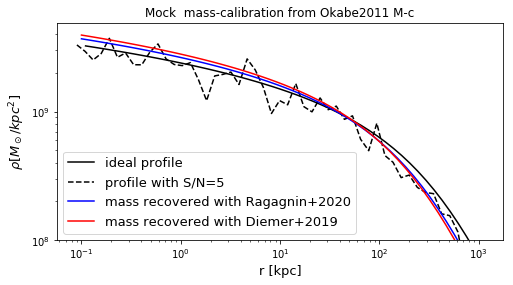

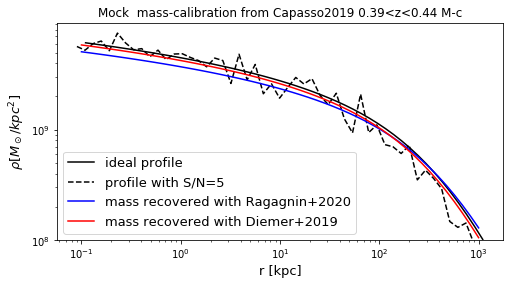

In [28]:
 
"""

fig,ax = plt.subplots(1,figsize=(8,4))
confronta(M = 5e14, sn=5.,  plotta=True, fig=fig, ax=ax, outputta=True)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([1e8,None])
ax.legend(fontsize=13)
ax.set_xlabel('r [kpc]',fontsize=13)
ax.set_ylabel(r'$\rho [M_\odot/kpc^2]$',fontsize=13)
print()

 


fig,ax = plt.subplots(1,figsize=(8,4))
confronta(M = 5e14, sn=5.,  plotta=True, fig=fig, ax=ax, outputta=True, model='Diemer2019')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([1e8,None])
ax.legend(fontsize=13)
ax.set_xlabel('r [kpc]',fontsize=13)
ax.set_ylabel(r'$\rho [M_\odot/kpc^2]$',fontsize=13)
print()

"""
fig,ax = plt.subplots(1,figsize=(8,4))
confronta(M = 5e14, sn=5.,  plotta=True, fig=fig, ax=ax, outputta=True, model='Okabe2011')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([1e8,None])
ax.legend(fontsize=13)
ax.set_xlabel('r [kpc]',fontsize=13)
ax.set_ylabel(r'$\rho [M_\odot/kpc^2]$',fontsize=13)
print()

"""


"""
fig,ax = plt.subplots(1,figsize=(8,4))
confronta(M = None, sn=5.,  plotta=True, fig=fig, ax=ax, outputta=True, model='Capasso2019 0.39<z<0.44')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([1e8,None])
ax.legend(fontsize=13)
ax.set_xlabel('r [kpc]',fontsize=13)
ax.set_ylabel(r'$\rho [M_\odot/kpc^2]$',fontsize=13)
print()

## 6) Perform N=1000 mass calibration Ragagnin2020 vs. Diemer2019

In [29]:


def confronta_n(n, M = 1e14, model = 'Ragagnin2020',  sn=None, plotta=False, bins=None, fig=None, ax=None, M1s=None, M3s=None, M2s=None):
    i=-1
    if M1s is None:
        M1s =[]
    if M2s is None:
        M2s =[]
    if M3s is None:
        M3s =[]
    _n=0.
    while True:
        i+=1
        try:
            _M, _M1, _M2, _M3 =  confronta(M = M, sn=sn, model=model)
            M1s.append(_M1)
            M2s.append(_M2)
            M3s.append(_M3)
            _n+=1
        except Exception as e:
            print
            print(e)
            pass
        if _n>n or i>10000:
            break
    #print(M1s)
    ra1 = np.array([x  for x in M1s])
    ra2 = np.array([x  for x in M2s])
    ra3 = np.array([x  for x in M3s])
    ra = ra1/ra2
    print('')
    print('model: ',model)
    print('ragagnin/orig: %.3f'%(np.mean(np.array(ra1/_M))))
    print('diemer/orig: %.3f'%(np.mean(np.array(ra2/_M))))
    print('ludlow/orig: %.3f'%(np.mean(np.array(ra3/_M))))
    print('')
    if plotta:
        if fig is None:
            fig,ax = plt.subplots(1,figsize=(8,4))

        # best fit of data
        (mu1, sigma1) = norm.fit(np.log(ra1/_M))
        (mu2, sigma2) = norm.fit(np.log(ra2/_M))
        #(mu3, sigma3) = norm.fit(np.log(ra3/_M))
       
        if bins is None:
            bins = np.linspace(-1.,1.,40)
        
        n, bins, patches =  ax.hist(np.log(ra1/_M) ,label = 'Ragagnin+2020', bins=bins, density=True,histtype=u'step',color='blue')
        y = mlab.normpdf( bins, mu1, sigma1)
        l = ax.plot(bins, y, '--', linewidth=2,c='blue')
        #print(mu1, sigma1)
        n, bins, patches =  ax.hist(np.log(ra2/_M ),label = 'Diemer+2019', bins=bins,density=True, histtype=u'step',color='red')
        y = mlab.normpdf( bins, mu2, sigma2)
        l = ax.plot(bins, y, '--', linewidth=2,c='red')
        
        #n, bins, patches =  ax.hist(np.log(ra3/_M) ,label = 'Ludlow+2016', bins=bins,density=True,  histtype=u'step',color='green')
        ## add a 'best fit' line
        #y = mlab.normpdf( bins, mu3, sigma3)
        #l = ax.plot(bins, y, '--', linewidth=2,c='green')
        #print(mu3, sigma3)
        
        #ax.axvline(9e13, label='Original Mass',color='black' )
        ax.text(.95,.95,'Mock  mass-calibration\nfrom %s M-c'%model,ha='right', va='top',
        transform=ax.transAxes,fontsize=13)
        ax.set_ylabel(r'$n$',fontsize=13)
         #ax.set_xscale('log')
        ax.axvline(0.)
    return M1s, M2s



/home/moon/ragagnin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in sqrt
/home/moon/ragagnin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in arccos
/home/moon/ragagnin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in arccosh
/home/moon/ragagnin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in power



model:  Ragagnin2020
ragagnin/orig: 1.080
diemer/orig: 0.878
ludlow/orig: nan



/home/moon/ragagnin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
/home/moon/ragagnin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: MatplotlibDeprecationWarning: scipy.stats.norm.pdf



model:  Okabe2011
ragagnin/orig: 1.020
diemer/orig: 0.849
ludlow/orig: nan



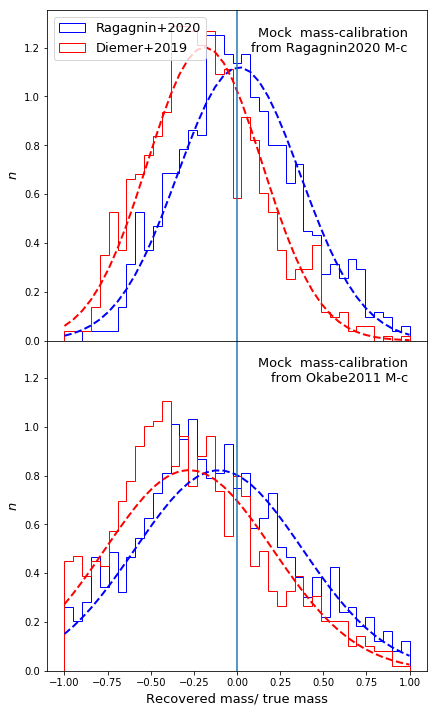

In [31]:
fig,ax = plt.subplots(2,figsize=(6,10),sharex=True,  sharey=True)
ax[-1] .set_xlabel('Recovered mass/ true mass',fontsize=13)
fig.tight_layout()
fig.subplots_adjust(wspace=0,  hspace=0)
#1/0

confronta_n(1000, sn=5., plotta=True, M=1e15, model='Ragagnin2020', bins =  np.linspace(-1.,1.,40), fig=fig,ax=ax [0])
confronta_n(1000, sn=5., plotta=True,  M=1e15,model='Okabe2011', bins =  np.linspace(-1.,1.,40),  fig=fig,ax=ax [1])
 

ax[0].legend(fontsize=13,loc=2)

/home/moon/ragagnin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in sqrt
/home/moon/ragagnin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in arccos
/home/moon/ragagnin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in arccosh
/home/moon/ragagnin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in power



model:  Ragagnin2020
ragagnin/orig: 1.065
diemer/orig: 0.868
ludlow/orig: nan



/home/moon/ragagnin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
/home/moon/ragagnin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: MatplotlibDeprecationWarning: scipy.stats.norm.pdf



model:  Okabe2011
ragagnin/orig: 0.964
diemer/orig: 0.807
ludlow/orig: nan



/home/moon/ragagnin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
/home/moon/ragagnin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: MatplotlibDeprecationWarning: scipy.stats.norm.pdf



model:  Capasso2019
ragagnin/orig: 1.673
diemer/orig: 1.392
ludlow/orig: nan



/home/moon/ragagnin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
/home/moon/ragagnin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: MatplotlibDeprecationWarning: scipy.stats.norm.pdf


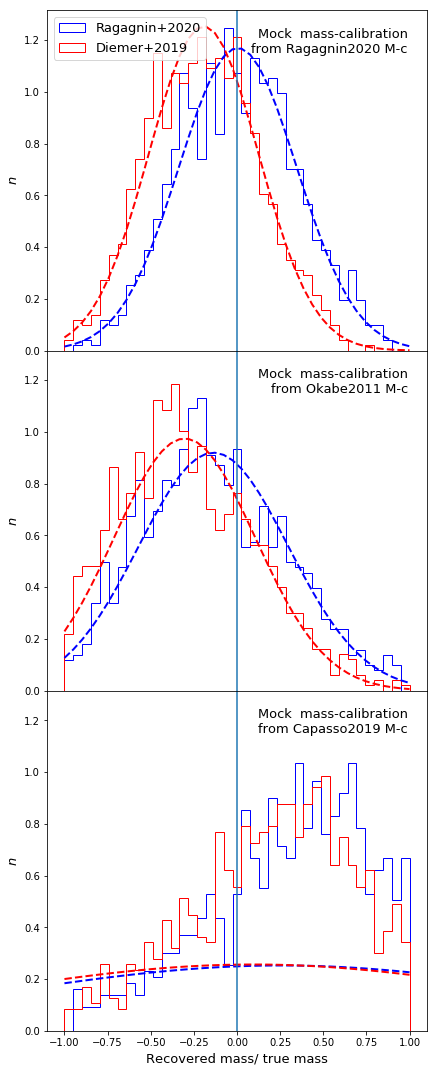

In [102]:
fig,ax = plt.subplots(3,figsize=(6,15),sharex=True,  sharey=True)
ax[-1] .set_xlabel('Recovered mass/ true mass',fontsize=13)
fig.tight_layout()
fig.subplots_adjust(wspace=0,  hspace=0)
#1/0

confronta_n(1000, sn=5., plotta=True, M=1e15, model='Ragagnin2020', bins =  np.linspace(-1.,1.,40), fig=fig,ax=ax [0])
confronta_n(1000, sn=5., plotta=True,  M=1e15,model='Okabe2011', bins =  np.linspace(-1.,1.,40),  fig=fig,ax=ax [1])
confronta_n(1000, sn=5., plotta=True,  M=None,model='Capasso2019', bins =  np.linspace(-1.,1.,40),  fig=fig,ax=ax [2])
 

ax[0].legend(fontsize=13,loc=2)